In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/utkarshgoyal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
df = pd.read_csv('b.csv', encoding = 'ISO-8859-1', usecols=[ 'Review', 'Rating'])
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,unique \tgreat stay \twonderful time hotel mon...,5
4,great stay great stay \twent seahawk game awes...,5


In [7]:
import re

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

def normalize(i):
#     for i in data:
    i = re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",i)
    
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)

    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [8]:
df['Review1'] = df.Review.apply(remove_stopwords)
df['Clean_Review'] = df['Review1'].apply(normalize)

df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)

In [9]:
df.head()

,Review,Rating,Review1,Clean_Review,posneg
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,0
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,0
3,unique \tgreat stay \twonderful time hotel mon...,5,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay \twent seahawk game awes...,5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,1


# TFIDF

In [10]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [12]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X = tfidf.fit_transform(df['Clean_Review'])
y = df['posneg'].values

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

## Random Forest

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7531105147596975
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2288
           1       0.78      0.61      0.69      1811

    accuracy                           0.75      4099
   macro avg       0.76      0.74      0.74      4099
weighted avg       0.76      0.75      0.75      4099



In [16]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

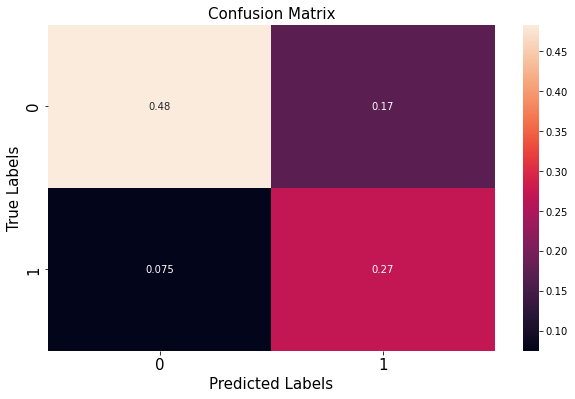

In [17]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
clf = LogisticRegression(C=5, solver='liblinear').fit(X_train, y_train)

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7901927299341303
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2288
           1       0.76      0.77      0.76      1811

    accuracy                           0.79      4099
   macro avg       0.79      0.79      0.79      4099
weighted avg       0.79      0.79      0.79      4099



In [21]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

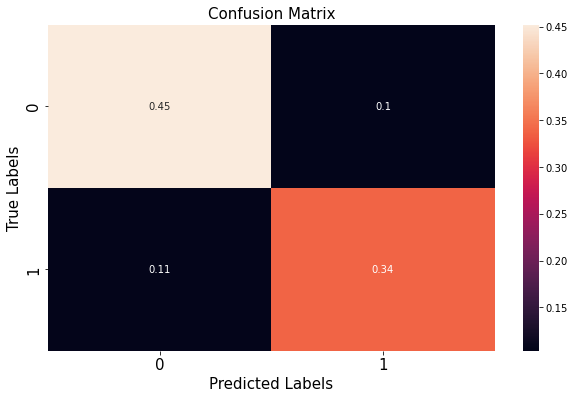

In [22]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

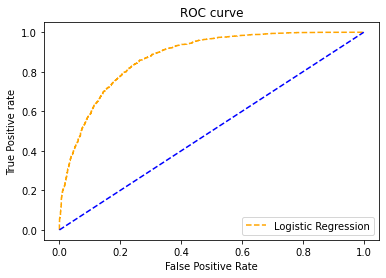

AUC score: 0.8749


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = clf.predict_proba(X_test)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])


fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

print('AUC score:',round(auc_score1, 4))